In [1]:
# Libraries and configuration that will be used in this blog post
import datetime
from datetime import date
import os
import warnings

#import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
#import rasterio as rio
import contextily as cx
import folium
import configparser

# Set working directory
os.chdir(os.path.join('E:/',
                      'McKinley'))

warnings.filterwarnings('ignore')

# Tracking the healing of a scared landscape...
***How can we use remote sensing and weather data to monitor vegetation restoration at a disused coal mine in New Mexico?***

## Restoring vegetation communities back to health
Damage to vegetation ecosystems often occurs at the sites where resources such as minerals, metals, and hydrocarbons are extracted. Once these resources are fully extracted and a project is closed then it is critical that the vegetation ecosystems are restored back to their pre-development or a better state. This includes restoring the natural vegetation state and rebuilding the soils of disturbed lands through either natural processes (plant succession) or man-made rewilding/reseeding efforts. The success of vegetation restoration efforts requires careful monitoring over many years to ensure that minimum thresholds are met with regards to vegetation cover, species makeup, function, and the health of the vegetation ecosystem.

## Project overview
For this project I am exploring the potential of using remote sensing and weather data to monitor the success of vegetation restoration measures at McKinley Mine, a closed open pit coal mine, in north-western New Mexico (see study area map below). For this work I have analyzed the archive Landsat 8 data going back to 2013 for different areas (seeding units, see plot below) at McKinley Mine that correspond to the different stages of revegetation. I have explored how trends in NDVI (Normalized Difference Vegetation Index) vary for the different seeding units and what impact weather has had on NDVI since 2013.

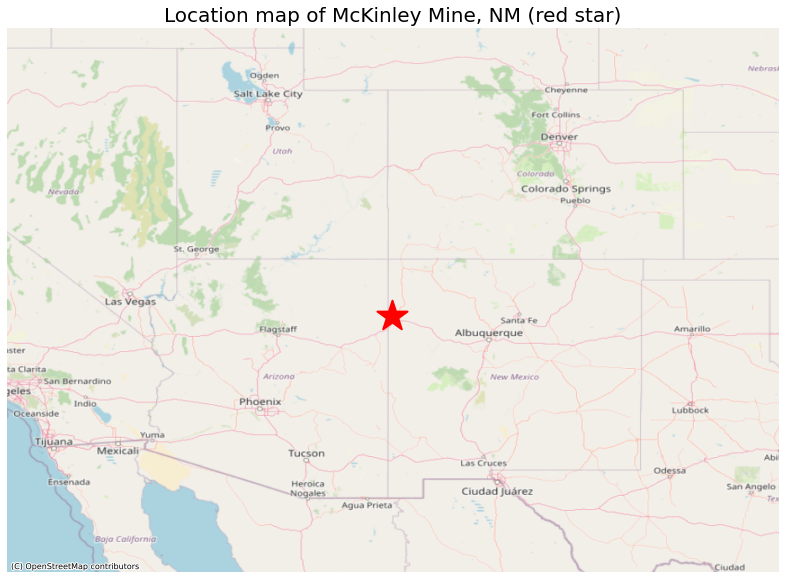

In [2]:
# Plot showing location map of McKinley Mine
# Import polygon for extent of location map
mckinley_aoi_large_path = os.path.join(
    'vectors', 'mckinley_large_figure_bounds.shp')
mckinley_aoi_large = gpd.read_file(mckinley_aoi_large_path)

# Import point polygon for McKinley Mine location
mckinley_location_path = os.path.join(
    'vectors', 'mckinley_location.shp')
mckinley_location = gpd.read_file(mckinley_location_path)

# Plot location map
fig, (ax) = plt.subplots(1, 1, figsize=(15, 10))

xlim = ([mckinley_aoi_large.total_bounds[0],
         mckinley_aoi_large.total_bounds[2]])
ylim = ([mckinley_aoi_large.total_bounds[1],
         mckinley_aoi_large.total_bounds[3]])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

mckinley_location.plot(ax=ax,
                       color='red',
                       marker='*',
                       markersize=1000,
                       linewidth=2
                       )

cx.add_basemap(ax, crs=mckinley_aoi_large.crs.to_string(),
               source=cx.providers.OpenStreetMap.Mapnik)

ax.set_title(
    "Location map of McKinley Mine, NM (red star)", fontsize=20)

ax.set_axis_off()

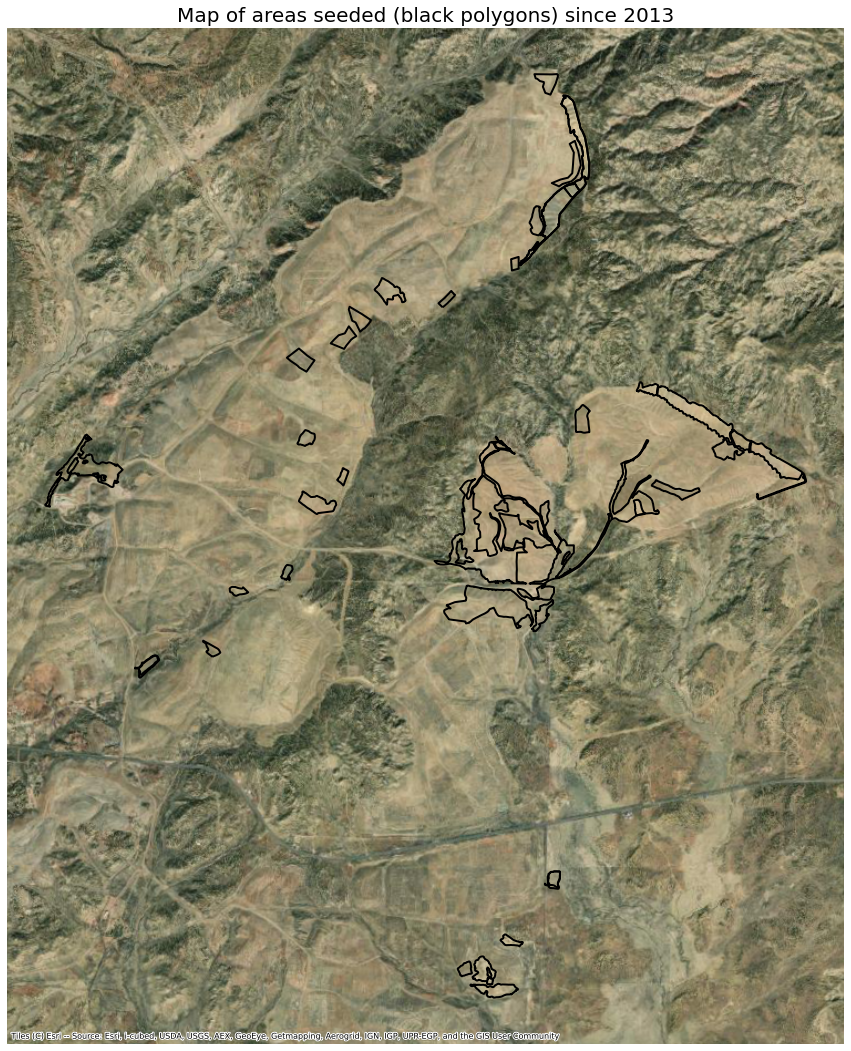

In [3]:
# Plot of seeding units
# Import seeding units shapefile
mckinley_seeding_path = os.path.join(
    'vectors', 'Golder_GIS_Data_Export_2021_04_27_Seeding', 'Seeding_Master_shifted.shp')
mckinley_seeding = gpd.read_file(mckinley_seeding_path)

# Clean up columns
mckinley_seeding_subset = mckinley_seeding.loc[:, [
    'Mine_Area', 'Start_Year', 'End_Year', 'GIS_Acre2', 'Agreement', 'Seed_Type', 'TYPE', 'geometry']]

# Remove rows older than 2013
drop = mckinley_seeding_subset[mckinley_seeding_subset['Start_Year'] < 2013].index
mckinley_seeding_subset.drop(drop, inplace=True)

# Filter polygons to remove roads, tracks, ROW's
# Calculate perimeter-area ratio
mckinley_seeding_subset['PAR'] = mckinley_seeding_subset.geometry.length / \
    mckinley_seeding_subset.geometry.area

# Filter by perimeter-area ratio
threshold = 0.01
mckinley_seeding_subset_PARlo = mckinley_seeding_subset[mckinley_seeding_subset['PAR'] < threshold]

# Plot the filtered seeding units
fig, (ax) = plt.subplots(1, 1, figsize=(15, 20))
mckinley_seeding_subset_PARlo.plot(ax=ax,
                                   color='None',
                                   edgecolor='black',
                                   linewidth=2)

cx.add_basemap(ax, crs=mckinley_seeding_subset_PARlo.crs.to_string(),
               source=cx.providers.Esri.WorldImagery)

ax.set_title(
    "Map of areas seeded (black polygons) since 2013", fontsize=20)

ax.set_axis_off()

## Analysis of Landsat 8 data
To access the archived Landsat 8 data I used a system called SentinelHub (https://www.sentinel-hub.com/) to search for available cloud free data covering the McKinley Mine site. I used SentinelHub to create an NDVI product that I clipped to the extent of McKinley Mine and then downloaded for subsequent analysis. For each of the seeding unit areas I then calculated an average NDVI value for each dataset acquired at different times. This provided a time series of NDVI values for each of the seeding units from 2013 to the current time (see example plots below). 

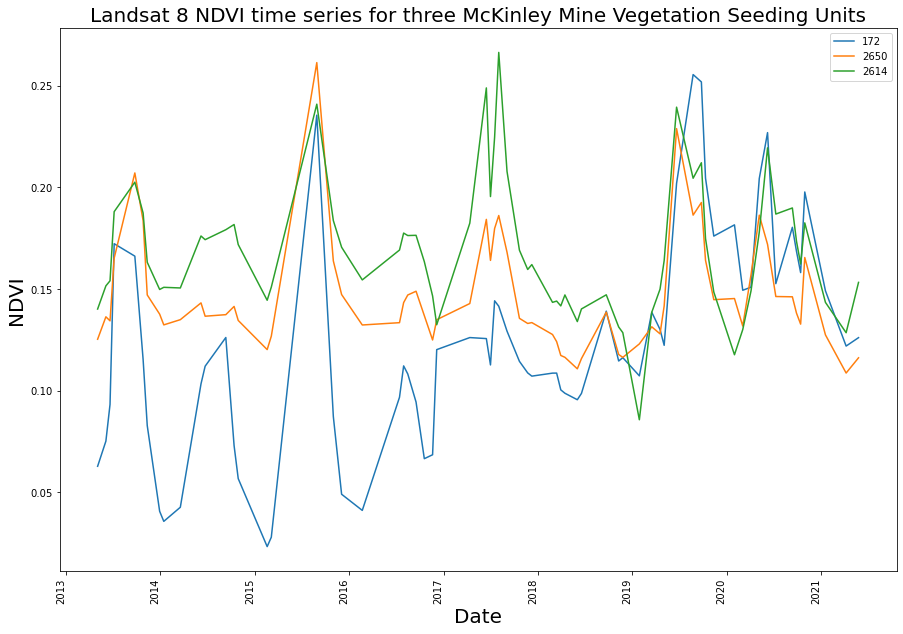

In [4]:
# Create plot for NDVI for seeding units
# Open the saved DF
%store -r landsat_8_time_series

# Setup plot
fig, ax = plt.subplots(figsize=(15, 10))

# Build list of unique seeding units for legend
seeding_units = [172, 2650, 2614]

# Subset data to just one seeding unit
landsat_8_time_series = landsat_8_time_series[(landsat_8_time_series['SuId'] == 172)
                                              | (landsat_8_time_series['SuId'] == 2650)
                                              | (landsat_8_time_series['SuId'] == 2614)]

landsat_8_time_series.reset_index().groupby(
    'SuId').plot(x='date', y='MeanNdvi', ax=ax)

# Legend and labels
plt.legend(seeding_units)

plt.xlabel("Date", fontsize=20)
plt.ylabel("NDVI", fontsize=20)

ax.set_title(
    "Landsat 8 NDVI time series for three McKinley Mine Vegetation Seeding Units", fontsize=20)

plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

plt.show()

The example time series data above from three separate seeding units indicates strong seasonal variation in NDVI values that is related to the greenup of vegetation (in particular grasses) in the spring and late summer and related senescence (drying out) of vegetation during other periods. The year to year variations in NDVI do show highs and lows that are likely related to interannual variation in rainfall. Aside from the seasonal variation in NDVI these plots do show longer term trends in NDVI; in particular for the examples shown above there is some convergence in the NDVI values with time. This likely indicates the longer term growth and recover of seeded areas.

## Identifying long term trends in NDVI
The long term trends in NDVI can sometimes be obscured by seasonal variation such as in the examples above. In order to better visualize how NDVI is changing over the long term I applied a smoothing algorithm to the time series data. Examples of the smoothed plots are shown below. These better visualize the long term trends in NDVI and in particular for one of the seeding units (172) the re-growth of vegetation. 

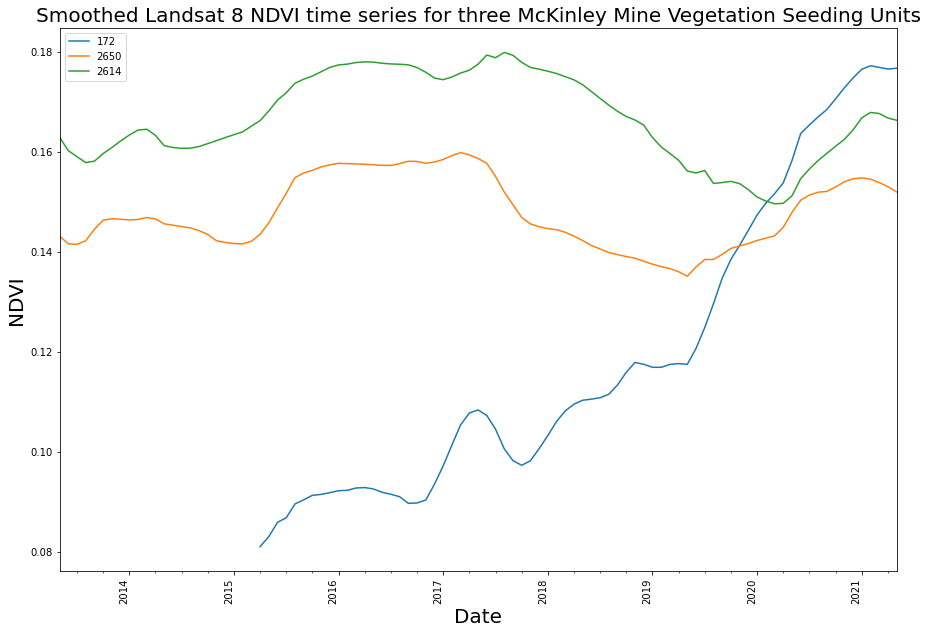

In [5]:
# Open the saved DF
%store -r landsat_8_time_series_rlmean

# Setup plot
fig, ax = plt.subplots(figsize=(15, 10))

landsat_8_time_series_rlmean = landsat_8_time_series_rlmean.reset_index()
landsat_8_time_series_rlmean = landsat_8_time_series_rlmean.set_index('date')

landsat_8_time_series_rlmean = landsat_8_time_series_rlmean[(landsat_8_time_series_rlmean['SuId'] == 172)
                                              | (landsat_8_time_series_rlmean['SuId'] == 2650)
                                              | (landsat_8_time_series_rlmean['SuId'] == 2614)]

landsat_8_time_series_rlmean.groupby('SuId').plot(y='MeanNdvi', ax=ax, use_index=True)

plt.xlabel("Date", fontsize=20)
plt.ylabel("NDVI", fontsize=20)

ax.set_title(
    "Smoothed Landsat 8 NDVI time series for three McKinley Mine Vegetation Seeding Units", fontsize=20)


# Legend and labels
plt.legend(seeding_units)

plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

plt.show()

## Interpreting the trends in NDVI
The next steps for this work will be to investigate what is controling the change in NDVI for the different seeding units at McKinley Mine. The trends could be related to when the areas were seeded or re-seeded or a function of weather/climate conditions or other factors. My plan will be to use some simple statistical models to understand how changes in NDVI could be linked to these controling factors.

## Potential tools for land managers
This work highlights the potential use of freely available remote sensing data to monitor vegetation restoration areas at a legacy coal mining site. Whilst further work is required, the initial results demonstrate that there are coherent trends in vegetation properties, as explored using NDVI, over time that are indicative of seasonal variation as well as long term trends. Both sets of information are of potential use to land managers involved with vegetation restoration projects. Understanding the timing of vegetation green is important when it comes to timing of vegetation surveys and the ability to monitor longer term trends is critical to ensuring that vegetation restoration measures are successful.

## Resources
GitHub repo is available here: https://github.com/haselwimmer/vegetation-restoration-monitoring